# Ensemble Perturbations: Contributions to Variance

In [1]:
import xarray as xr
import numpy as np
import glob
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import scipy.signal as signal
import scipy.stats as stats
import esmtools.stats as esmstat

In [7]:
def read_ensemble(name):
    f1 = sorted(glob.glob('/glade/scratch/mollyw/archive/'+name+'/ice/proc/tseries/day_1/'+name+'.ci*[0-9]*.h1.hi.20150101-20191231.nc'))
    # f2 = sorted(glob.glob('/glade/scratch/mollyw/archive/free_Cf/ice/proc/tseries/day_1/free_Cf.ci*[0-9]*.h1.vicen.20150101-20191231.nc'))

    ds = xr.open_mfdataset(f1, combine='nested', concat_dim='ensemble_member')
    # ds_aicen = xr.open_mfdataset(f2, combine='nested', concat_dim='ensemble_member')

    # ds = xr.merge([ds_vicen, ds_aicen])
    cice_grid = xr.open_dataset('~/Projects/cice_grid.nc')
    cice_area = cice_grid.tarea*1e-9

    vice = ds.hi * 1e-3 * cice_area
    volume = vice.sum(dim = ['ni','nj']) 

    ds["volume"] = volume

    return ds

In [8]:
ds = read_ensemble('free_Cf')

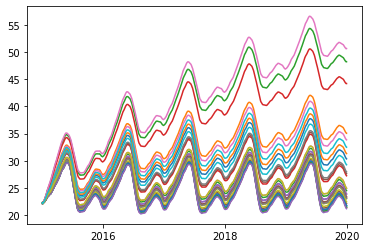

In [12]:
plt.plot(ds.time, ds.volume.transpose('time','ensemble_member'))

In [13]:
ds = read_ensemble('free_ksno')

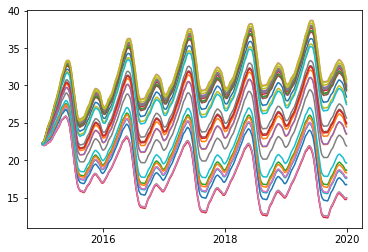

In [14]:
plt.plot(ds.time, ds.volume.transpose('time','ensemble_member'))

In [17]:
ds = read_ensemble('free_systemic')

In [ ]:
def convert_coords(lat, lon, og_data, ccrs_grid):
    """ convert data to appropriate coordinates for ccrs plot """
    
    grid = ccrs_grid
    coords = grid.transform_points(ccrs.PlateCarree(), 
                                   np.array(lon), 
                                   np.array(lat))
    
    xs = np.ma.masked_invalid(coords[..., 0])
    ys = np.ma.masked_invalid(coords[..., 1])
    data = np.ma.masked_invalid(og_data)
    data.mask = np.logical_or(data.mask, xs.mask, ys.mask)
    
    xs = xs.filled(0)
    ys = ys.filled(0)
    
    return xs,ys,data

def fashion_space(ax):
    """ set standard design paramaters for hemispheric stereo plots """
    
    ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND,facecolor = 'gainsboro', zorder=6)
    ax.gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = matplotlib.path.Path(verts * radius + center)
    
    ax.set_boundary(circle, transform=ax.transAxes)
    
def plot_nps(data_array, bounds, cmap):
    """ plot a NorthPolarStereo map """
    
    data = data_array
    lat = data_array.lat
    lon = data_array.lon
    nps = ccrs.NorthPolarStereo()
    
    xs,ys,plot_data=convert_coords(lat, lon, data, nps)
    
    # fig = plt.figure(figsize = (6,6))
    ax = plt.gca() #axes(projection=nps)
    fashion_space(ax)
    # cmap = plt.cm.cubehelix_r
    clevs_label = np.linspace(bounds[0], bounds[1], 11)
    clevs = np.linspace(bounds[0], bounds[1], 21)
    img = ax.contourf(xs, ys, data,clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
    cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)

In [20]:
def difference(dataset, interval=1):
    """ Calculate the difference between two timesteps of a timeseries at a prescribed 
        interval.
        
        Inputs: xr.DataArray or xr.DataSet timeseries
        Output: differenced array as an xr.DataArray
    """
    
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    
    diff_array = xr.DataArray(diff, 
                              coords=dataset.isel(time = slice(0,-1*interval)).coords, 
                              dims=dataset.isel(time = slice(0,-1*interval)).dims, 
                              attrs=dataset.isel(time = slice(0,-1*interval)).attrs
                             )
    return diff_array

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """ Input: Two xr.Datarrays of any dimensions with the first dim being time. 
        Thus the input data could be a 1D time series, or for example, have three 
        dimensions (time,lat,lon). 
        Datasets can be provided in any order, but note that the regression slope 
        and intercept will be calculated for y with respect to x.
        Output: Covariance, correlation, regression slope and intercept, p-value, 
        and standard error on regression between the two datasets along their 
        aligned time dimension.  
        Lag values can be assigned to either of the data, with lagx shifting x, and
        lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:

        # If x lags y by 1, x must be shifted 1 step backwards. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid 
        # (nan). Hence it needs to be dropped
        # x   = x.shift(time = -lagx) #.dropna(dim='time')
        x   = x.shift(time = -lagx) #.dropna(dim='time')
    
        # Next important step is to re-align the two datasets so that y adjusts
        # to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        # y   = y.shift(time = -lagy)#.dropna(dim='time')
        y   = y.shift(time = -lagy) #.dropna(dim='time')
        x,y = xr.align(x,y)

    #3. Compute data length, mean and standard deviation along time axis: 
    n = y.notnull().sum(dim='time')
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)

    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    return cov, cor
    
def define_markov(timeseries, lag, interval):
    """ Expresses the evolution of a timeseries's detrended and deasonalized anomalies 
        as a Markov process with some lagged autocorrelation (or persistence) and some 
        projected external forcing. 
        
        Returns the anomalies of the timeseries (h_prime), the lagged autocorrelation
        (autocorrelation), and the external forcing projection's contribution to the 
        total anomaly at each timestep (external).
        
        Input: a timeseries (1-3 dimensional) in the form of an xarray.DataArray
        Ouputs: h_prime, autocorrelation, and external in the form of xarray.DataArrays
    """ 
    
    # detrend
    if interval != 1:
        detrended = timeseries.diff(dim='time', n=1)
    else:
        detrended = timeseries
        
    # deseasonalize 
    deseasonalized = difference(detrended, interval)
    # deseasonalized = detrended
    
    # determine autocorrelation
    # A = esmstat.autocorr(deseasonalized, dim = 'time', nlags = lag)
    null, A = lag_linregress_3D(deseasonalized, deseasonalized, lagx=0, lagy=lag-1)
    autocorrelation = A#[1]
    
    # get day_1 and day_n-1
    h_prime = deseasonalized[1:,:,:]
    h_prime_nm1 = deseasonalized[0:-1,:,:]
    
    # calculate external contributions
    external = h_prime - autocorrelation*h_prime_nm1
    
    return h_prime, autocorrelation, external
    
def markov_variance(h_prime, autocorrelation, external):
    """ Calculate the total variance of a timeseries, and that of each of it's Markov
        components. Return each variance as an xr.DataArray object.
        
        Inputs:
        Outputs: variance in xr.DataArray; ratio of variance (approximation and calculated)
    """
    
    # calculate total variance
    total_squared = h_prime**2
    temp = 1/(len(total_squared)-1) * total_squared.sum(dim = 'time', skipna = True)
    variance = temp.where(temp > 0)
    
    # calculate external variance
    ext_squared = external**2
    ext_temp = 1/(len(ext_squared)-1) * ext_squared.sum(dim = 'time', skipna=True)
    ext_variance = ext_temp.where(ext_temp > 0)

    # assume difference is related to persistence
    pst = h_prime - external
    pst_squared = pst**2
    pst_temp = 1/(len(pst_squared)-1) * pst_squared.sum(dim = 'time', skipna=True)
    pst_variance = pst_temp.where(pst_temp > 0)
    
    # calculate the ratio of external variance to the persistence approximation
    ratio_approx = ext_variance/(1-autocorrelation)
    
    # calculate the ratio of external variance to persistence variance
    ratio_straight = ext_variance/pst_variance
    
    return variance, pst_variance, ext_variance, ratio_approx, ratio_straight

In [ ]:
cice_grid = xr.open_dataset('~/Projects/cice_grid.nc')
cice_area = cice_grid.tarea

In [18]:
ens_mean_h_eff = ds.mean(dim = 'ensemble_member').hi

In [24]:
ens_mean_h_eff = ens_mean_h_eff.where(ens_mean_h_eff.ULAT > 50)

In [25]:
h_prime, A, external = define_markov(ens_mean_h_eff, lag = 2, interval = 365)

/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mollyw/.conda/envs/markov_model

KeyboardInterrupt: 

In [ ]:
plt.plot(h_prime.where(h_prime.lat > 0))
plt.plot(external.)
plt.plot(h_prime-external)

In [27]:
thing = ens_mean_h_eff.diff(dim='time', n=1)

In [31]:
thing2 = difference(thing, interval=365)

/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mollyw/.conda/envs/markov_model

KeyboardInterrupt: 